In [85]:
from copy import deepcopy
from time import time

import torch
import torch.nn.functional as F

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd

from torchvision.datasets import FashionMNIST
from torchvision import transforms

In [94]:
def acc(net_output, labels):
    predicted = net_output.argmax(dim=1)
    correct = (predicted == labels).sum()
    examples = len(labels)
    return (correct / examples).item()


class FMnistNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [95]:
ds_train = FashionMNIST(
    root="./data", 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
    ]), 
    download=True, 
    train=True)

ds_test = FashionMNIST(
    root="./data", 
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
    ]), 
    download=True,
    train=False)

In [96]:
train_set = DataLoader(ds_train, batch_size=64, shuffle=True, num_workers=4)
test_set = DataLoader(ds_test, batch_size=len(ds_train))

In [131]:
net = FMnistNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

total_epochs = 0
train_loss_progress = []
test_loss_progress = []
train_acc_progress = []
test_acc_progress = []

In [140]:
epochs_per_run=43
total_epochs += epochs_per_run

for epoch in range(total_epochs-epochs_per_run, total_epochs):
    epoch_start = time()
    
    accum_loss = []
    accum_acc = []
    
    for data, labels in train_set:
        optimizer.zero_grad()
        net_output = net(data)
        loss = loss_fn(net_output, labels)
        loss.backward()
        optimizer.step()
        
        accum_loss.append(loss.item())
        accum_acc.append(acc(net_output, labels))
    
    epoch_duration = time() - epoch_start
        
    train_avg_loss = np.mean(accum_loss)
    train_avg_acc = np.mean(accum_acc)
    
    with torch.no_grad():
        test_data, test_labels = next(iter(test_set))
        test_output = net(test_data)
        test_loss = loss_fn(test_output, test_labels)
        test_acc = acc(test_output, test_labels)    
        
    train_loss_progress.append(train_avg_loss)
    test_loss_progress.append(test_loss.item())
    train_acc_progress.append(train_avg_acc)
    test_acc_progress.append(test_acc)
    
    print(f"EPOCH {epoch+1}/{total_epochs} -- train: (loss: {train_avg_loss:.4f}, acc: {100*train_avg_acc:.2f}%), test: (loss: {test_loss:.4f}, acc: {100*test_acc:.2f}%), time: {epoch_duration:.2f}s")

EPOCH 8/50 -- train: (loss: 1.5914, acc: 87.04%), test: (loss: 1.6034, acc: 85.77%), time: 8.17s
EPOCH 9/50 -- train: (loss: 1.5877, acc: 87.37%), test: (loss: 1.6002, acc: 86.13%), time: 7.76s
EPOCH 10/50 -- train: (loss: 1.5852, acc: 87.62%), test: (loss: 1.6136, acc: 84.56%), time: 7.81s
EPOCH 11/50 -- train: (loss: 1.5842, acc: 87.70%), test: (loss: 1.6000, acc: 86.10%), time: 13.56s
EPOCH 12/50 -- train: (loss: 1.5815, acc: 87.99%), test: (loss: 1.5897, acc: 87.19%), time: 8.37s
EPOCH 13/50 -- train: (loss: 1.5787, acc: 88.22%), test: (loss: 1.5978, acc: 86.33%), time: 7.79s
EPOCH 14/50 -- train: (loss: 1.5766, acc: 88.46%), test: (loss: 1.5929, acc: 86.82%), time: 7.84s
EPOCH 15/50 -- train: (loss: 1.5747, acc: 88.62%), test: (loss: 1.6016, acc: 85.94%), time: 8.19s
EPOCH 16/50 -- train: (loss: 1.5743, acc: 88.68%), test: (loss: 1.5888, acc: 87.17%), time: 7.91s
EPOCH 17/50 -- train: (loss: 1.5726, acc: 88.84%), test: (loss: 1.5897, acc: 87.09%), time: 7.88s
EPOCH 18/50 -- train:

In [141]:
metadata_df = pd.DataFrame((train_loss_progress, test_loss_progress, train_acc_progress, test_acc_progress)).T
metadata_df.columns = ["train_loss", "test_loss", "train_acc", "test_acc"]
metadata_df['epoch'] = np.arange(1, total_epochs+1)
metadata_df = metadata_df.set_index('epoch')

<AxesSubplot:xlabel='epoch'>

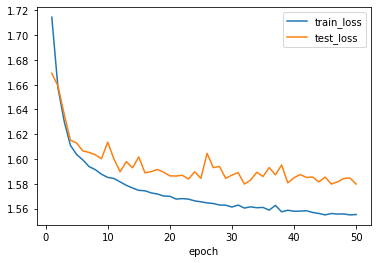

In [142]:
metadata_df[['train_loss', 'test_loss']].plot(kind='line')

<AxesSubplot:xlabel='epoch'>

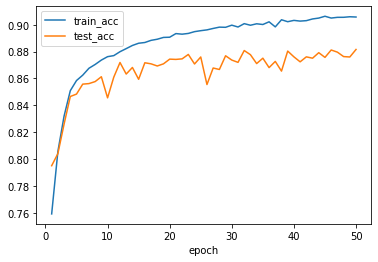

In [143]:
metadata_df[['train_acc', 'test_acc']].plot()